# GFA Dark Calibration

This notebook should be run using a DESI kernel, e.g. `DESI master`.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
import sys
import json
import collections
from pathlib import Path

In [4]:
import scipy.interpolate

In [5]:
import fitsio

Install / upgrade the `desietcimg` package:

In [6]:
try:
    import desietcimg
    print('desietcimg already installed')
except ImportError:
    print('Installing desietcimg...')
    !{sys.executable} -m pip install --user git+https://github.com/dkirkby/desietcimg

desietcimg already installed


In [7]:
upgrade = False
if upgrade:
    print('Upgrading desietcimg...')
    !{sys.executable} -m pip install --upgrade --user git+https://github.com/dkirkby/desietcimg

In [8]:
import desietcimg.util
import desietcimg.plot
import desietcimg.gfa

NERSC configuration:

In [9]:
assert os.getenv('NERSC_HOST', False)

In [10]:
ROOT = Path('/project/projectdirs/desi/spectro/data/')
assert ROOT.exists()

## Process Dome Dark Sequences

In [11]:
darks = {}

In [12]:
def process_darks(night, first, last):
    files = desietcimg.util.find_files(
        ROOT / str(night) / '{N}/gfa-{N}.fits.fz', min=first, max=last,
        partial_match_is_error=False)
    nexp = len(files)
    print('Processing {0} exposures from {1}...'.format(nexp, night))
    GFA = desietcimg.gfa.GFACamera(calib_name='/global/cscratch1/sd/dkirkby/GFA_calib.fits')
    ngfa = len(GFA.gfa_names)
    mjd = np.empty((ngfa, nexp))
    temp = np.empty((ngfa, nexp))
    sigmed = np.empty((ngfa, nexp))
    for k, gfa in enumerate(GFA.gfa_names):
        raw, meta = desietcimg.util.load_raw(files, 'EXPTIME', 'MJD-OBS', 'GCCDTEMP', hdu=gfa)
        # Check that all exposures have the same length.
        texp = meta['EXPTIME'][0]
        assert np.all(meta['EXPTIME'] == texp)
        if k == 0:
            print('Exposure time is {0:.1f}s'.format(texp))
        # Save this camera's timestamps and temperatures.
        mjd[k] = meta['MJD-OBS']
        temp[k] = meta['GCCDTEMP']
        # Calculate and save this camera's median signal in elec/s in each exposure.
        GFA.setraw(raw, name=gfa)
        sigmed[k] = np.median(GFA.data / texp, axis=(1, 2))
    if first in darks:
        print('Replacing previous results')
    darks[first] = dict(
        night=night, last=last, nexp=nexp, texp=texp,
        mjd=mjd, temp=temp, sigmed=sigmed)

In [13]:
%time process_darks(20191105, 24514, 24713)

Processing 200 exposures from 20191105...
Exposure time is 5.0s
CPU times: user 2min 44s, sys: 42.4 s, total: 3min 26s
Wall time: 6min 31s


In [14]:
%time process_darks(20191109, 25742, 25777)

Processing 36 exposures from 20191109...
Exposure time is 5.0s


CPU times: user 26.8 s, sys: 3.73 s, total: 30.6 s
Wall time: 36 s


In [15]:
%time process_darks(20191109, 25838, 25937)

Processing 100 exposures from 20191109...
Exposure time is 5.0s


CPU times: user 1min 14s, sys: 12 s, total: 1min 26s
Wall time: 2min 1s


In [16]:
%time process_darks(20191110, 25988, 26087)

Processing 100 exposures from 20191110...
Exposure time is 5.0s
CPU times: user 1min 15s, sys: 11.9 s, total: 1min 27s
Wall time: 2min 57s


In [17]:
%time process_darks(20191110, 26088, 26192) # includes some spectrograph zeros

Processing 100 exposures from 20191110...
Exposure time is 5.0s
CPU times: user 1min 14s, sys: 11.9 s, total: 1min 26s
Wall time: 2min 7s


In [18]:
%time process_darks(20191110, 26439, 26538)

Processing 100 exposures from 20191110...
Exposure time is 5.0s
CPU times: user 1min 16s, sys: 11.9 s, total: 1min 28s
Wall time: 2min 20s


In [19]:
%time process_darks(20191110, 26584, 26684) # 26604 is a 900s spectrograph dark

Processing 100 exposures from 20191110...
Exposure time is 5.0s
CPU times: user 1min 16s, sys: 13.2 s, total: 1min 29s
Wall time: 2min 15s


In [20]:
%time process_darks(20191110, 26730, 26829)

Processing 100 exposures from 20191110...
Exposure time is 5.0s
CPU times: user 1min 16s, sys: 13.8 s, total: 1min 30s
Wall time: 2min 10s


In [21]:
%time process_darks(20191110, 26859, 26958)

Processing 100 exposures from 20191110...
Exposure time is 5.0s


CPU times: user 1min 14s, sys: 12.6 s, total: 1min 27s
Wall time: 1min 58s


## Bin Dark Current and Temperature During Each Sequence

In [22]:
def bin_time_dependence(first, ntbins='auto', dtmin=None, dtmax=None, bad=''):
    ngfa = len(desietcimg.gfa.GFACamera.gfa_names)
    badgfas = bad.split(',')
    data = darks[first]
    mjd, temp, sigmed = data['mjd'], data['temp'], data['sigmed']
    # Convert to elapsed minutes
    dt = (mjd - mjd.min()) * 24 * 60
    # Determine the elapsed time binning to use.
    if ntbins == 'auto':
        ntbins = int(round(data['nexp'] / 15))
    if dtmin is None:
        dtmin = 0
    if dtmax is None:
        dtmax = 1.001 * dt.max()
    print('Using {0} bins for {1}-{2} on {3}'.format(ntbins, first, data['last'], data['night']))
    # Define equally spaced bins in elapsed time.
    dtbins = np.linspace(dtmin, dtmax, ntbins + 1)
    dtgrid = 0.5 * (dtbins[1:] + dtbins[:-1])
    idx = np.digitize(dt, dtbins) - 1
    # Calculate summaries in each bin.
    dtsum = np.empty((ngfa, ntbins))
    tempsum = np.empty((ngfa, ntbins))
    sigmedsum = np.empty((ngfa, ntbins))
    for j in range(ntbins):
        for k in range(ngfa):
            sel = (idx[k] == j)
            dtsum[k, j] = np.mean(dt[k, sel])
            tempsum[k, j] = np.median(temp[k, sel])
            sigmedsum[k, j] = np.median(sigmed[k, sel])
            
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    for k, gfa in enumerate(desietcimg.gfa.GFACamera.gfa_names):
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][k]
        ax[0].plot(dt[k], temp[k], '.', c=c, alpha=0.2)
        ax[1].plot(dt[k], sigmed[k], '.', c=c, alpha=0.2)
        fmt = 'x--' if gfa in badgfas else 'o-'
        ax[0].plot(dtsum[k], tempsum[k], fmt, c=c, label=gfa)
        ax[1].plot(dtsum[k], sigmedsum[k], fmt, c=c, label=gfa)
    for axis in ax:
        axis.legend(ncol=5)
        axis.set_xlim(dt.min(), dt.max())
    ax[0].set_ylabel('Median CCD Temperature [C]')
    ax[1].set_ylabel('Median Dark Current [elec/s]')
    ax[1].set_xlabel('Elapsed Time $t$ [min]')
    plt.tight_layout()
    
    if 'dtsum' in data:
        print('Replacing previous binned results')
    data['dtsum'] = dtsum
    data['tempsum'] = tempsum
    data['sigmedsum'] = sigmedsum
    data['bad'] = badgfas

If the data for some GFAs looks bad, add it to the optional `bad` list and rerun. Set the number of time bins manually if needed.

Using 13 bins for 24514-24713 on 20191105


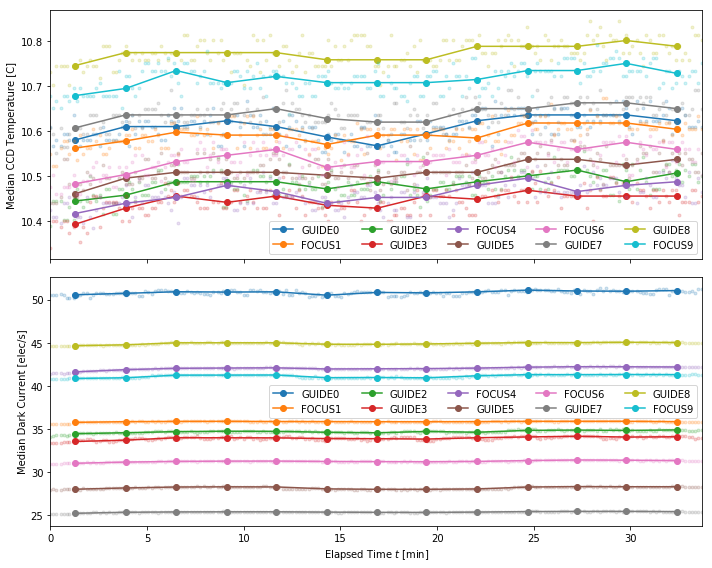

In [23]:
bin_time_dependence(24514)

Using 3 bins for 25742-25777 on 20191109


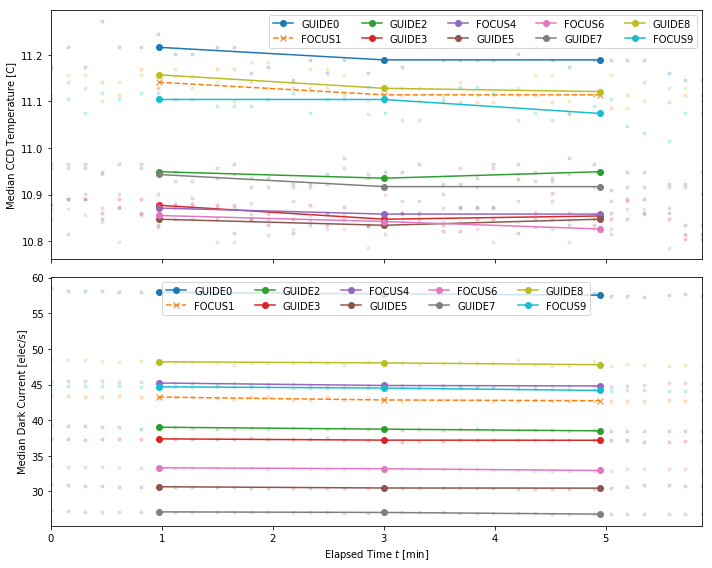

In [24]:
bin_time_dependence(25742, ntbins=3, bad='FOCUS1')

Using 7 bins for 25838-25937 on 20191109


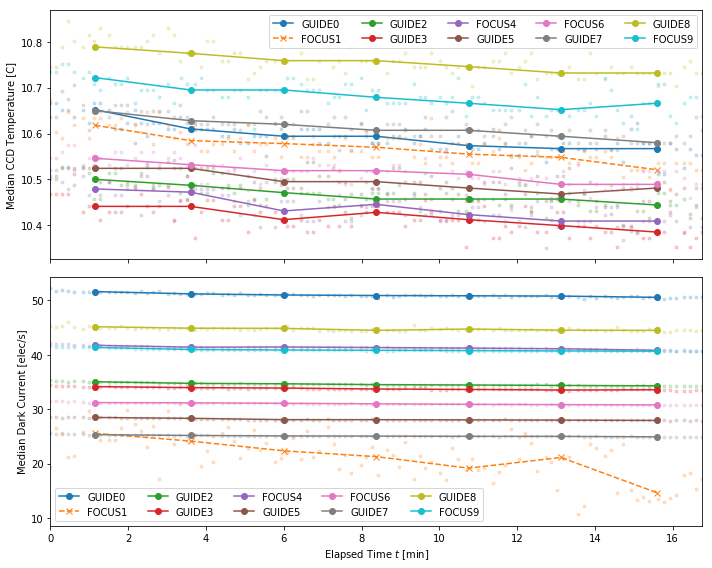

In [25]:
bin_time_dependence(25838, bad='FOCUS1')

Using 7 bins for 25988-26087 on 20191110


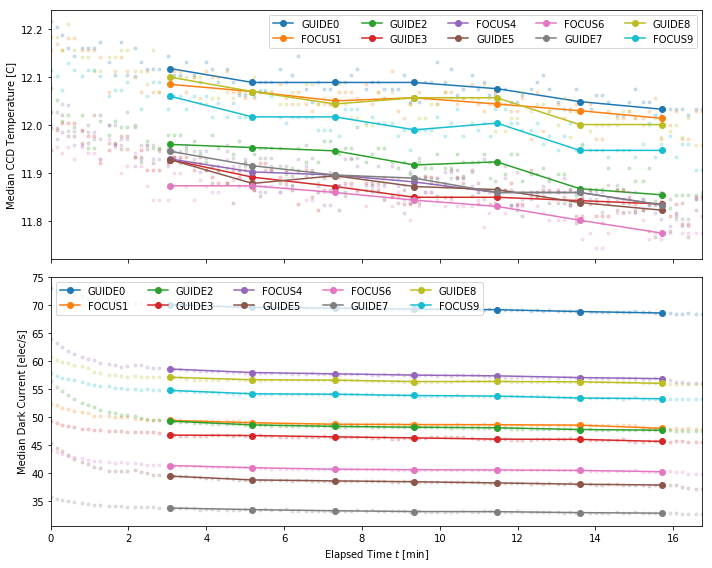

In [26]:
bin_time_dependence(25988, dtmin=2)

Using 7 bins for 26088-26192 on 20191110


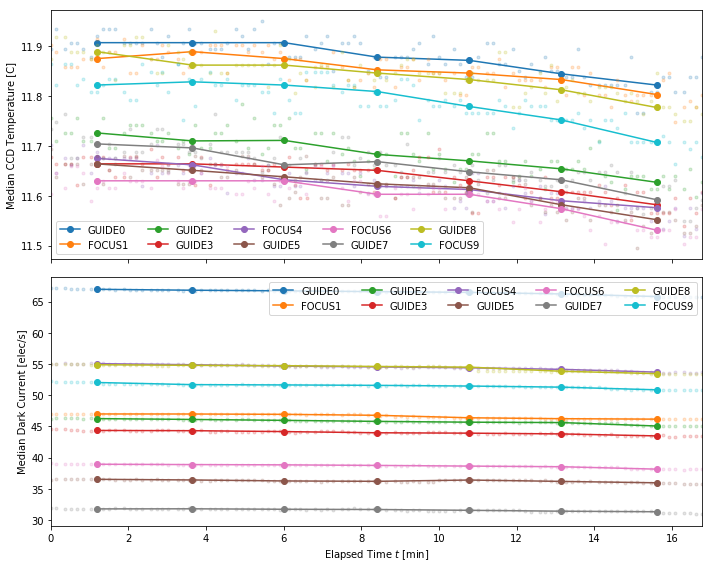

In [27]:
bin_time_dependence(26088)

Using 7 bins for 26439-26538 on 20191110


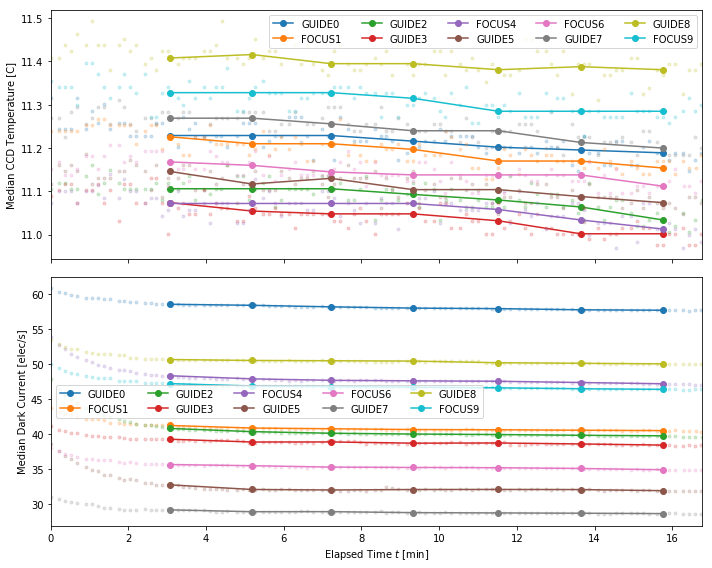

In [28]:
bin_time_dependence(26439, dtmin=2)

Using 7 bins for 26584-26684 on 20191110


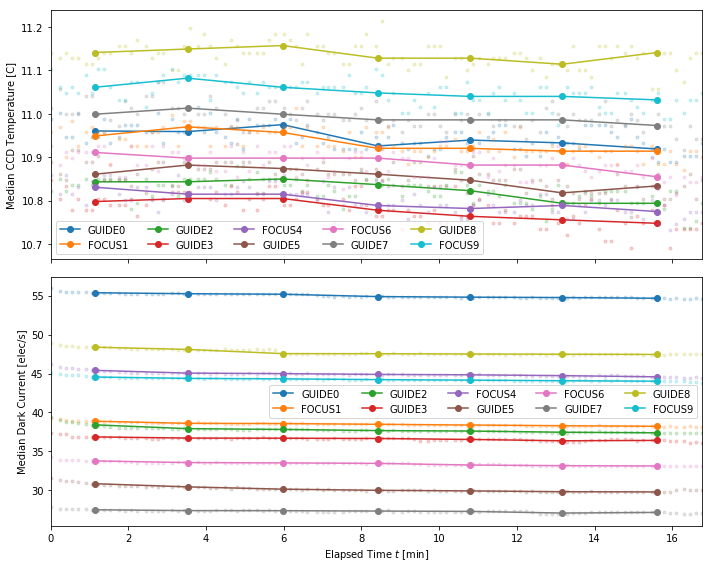

In [29]:
bin_time_dependence(26584)

Using 7 bins for 26730-26829 on 20191110


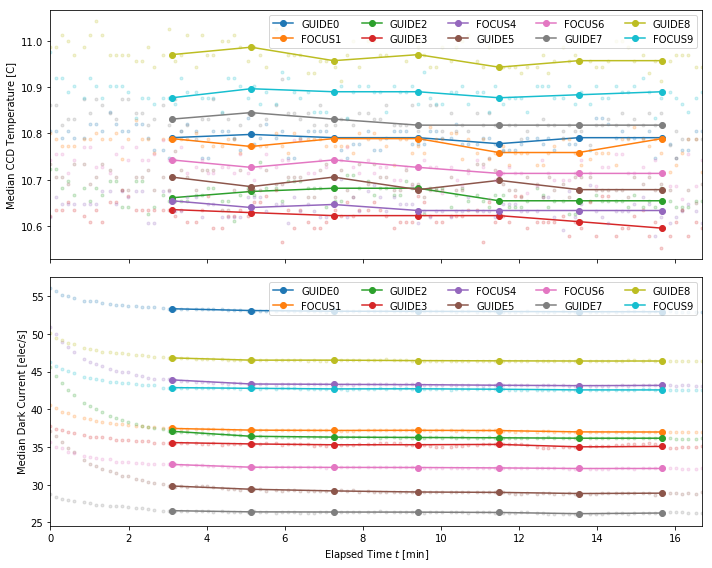

In [30]:
bin_time_dependence(26730, dtmin=2)

Using 7 bins for 26859-26958 on 20191110


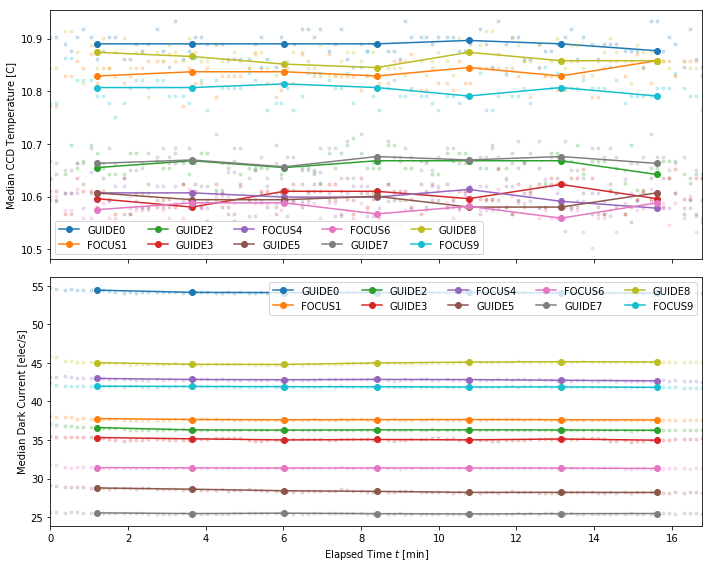

In [31]:
bin_time_dependence(26859)

## Fit Temperature Dependence

In [32]:
def fit_time_dependence(TREF=11, save='GFA_temp_fit.png'):
    results = {}
    fig, axes = plt.subplots(5, 2, sharex=True, figsize=(18, 11))
    for k, gfa in enumerate(desietcimg.gfa.GFACamera.gfa_names):
        ax = axes[k // 2, k % 2]
        # Concatenate the binned temperature and dark current values to fit.
        Tvec, Svec = [], []
        for first, data in darks.items():
            T = data['tempsum'][k]
            S = data['sigmedsum'][k]
            if gfa in data['bad']:
                print('Ignoring {0} from {1}-{2} on {3}.'.format(gfa, first, data['last'], data['night']))
                fmt = 'x'
                bad = True
            else:
                fmt = '+'
                bad = False
            ax.plot(T, S, fmt, label=str(first))
            if not bad:
                Tvec.append(T)
                Svec.append(S)
        T = np.concatenate(Tvec)
        S = np.concatenate(Svec)
        # Perform a linear fit.
        p1, p0 = np.polyfit(T - TREF, S, deg=1)
        # Calculate and plot the best-fit prediction.
        xline = np.percentile(T, (0, 100))
        yline = p0 + p1 * (xline - TREF)
        ax.plot(xline, yline, 'k-', alpha=0.5)
        ax.set_ylim(0.95 * yline[0], 1.05 * yline[1])
        results[gfa] = dict(TREF=TREF, TCOEF=p1 / p0, IREF=p0)
        if k in (8, 9):
            ax.set_xlabel('GFA CCD Temperature [C]')
        title = '{0} {1:.1f} e/s {2:+.1f}%/C'.format(gfa, p0, 100 * p1 / p0)
        ax.legend(ncol=2, title=title)
        ax.set_ylabel('Dark Current [e/s]')
        ax.axvline(TREF, ls=':', c='k')
        #ax.axhline(p0, ls=':', c='k')
    plt.tight_layout()
    if save:
        plt.savefig(save)    
    return results

Ignoring FOCUS1 from 25742-25777 on 20191109.
Ignoring FOCUS1 from 25838-25937 on 20191109.


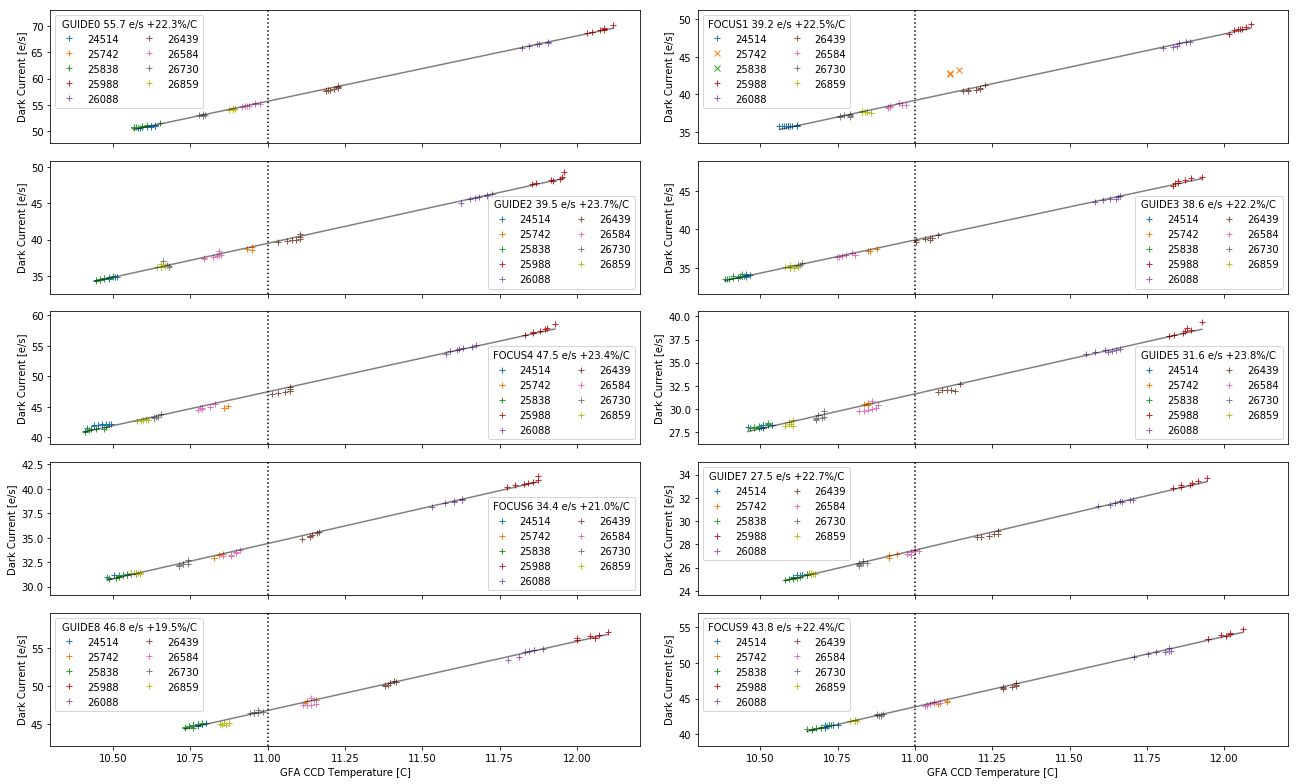

In [33]:
fitresults = fit_time_dependence()

In [34]:
repr(fitresults)

"{'GUIDE0': {'TREF': 11, 'TCOEF': 0.22312382450590432, 'IREF': 55.67309831687179}, 'FOCUS1': {'TREF': 11, 'TCOEF': 0.22459384191819964, 'IREF': 39.216129483143845}, 'GUIDE2': {'TREF': 11, 'TCOEF': 0.23709185385155998, 'IREF': 39.479133350716864}, 'GUIDE3': {'TREF': 11, 'TCOEF': 0.22248079909752966, 'IREF': 38.610830497720826}, 'FOCUS4': {'TREF': 11, 'TCOEF': 0.23382446653410816, 'IREF': 47.46612085852998}, 'GUIDE5': {'TREF': 11, 'TCOEF': 0.23781578885439641, 'IREF': 31.630381567453274}, 'FOCUS6': {'TREF': 11, 'TCOEF': 0.20954294753899028, 'IREF': 34.40713139372018}, 'GUIDE7': {'TREF': 11, 'TCOEF': 0.2267895098917595, 'IREF': 27.5031294544596}, 'GUIDE8': {'TREF': 11, 'TCOEF': 0.1954715102399018, 'IREF': 46.75603071940558}, 'FOCUS9': {'TREF': 11, 'TCOEF': 0.2243704920834549, 'IREF': 43.84326255069195}}"

## Build Master Dark Images

Build a master dark for each GFA using the same exposures used in the temperature fit.  Each exposure is corrected to TREF using a smoothed temperature estimate to calculate a median of corrected exposures from each sequence that is immune to cosmics.  Finally, the median dark images from each sequence are averaged for the final master dark.

In [35]:
def build_master_dark():
    master_dark = {}
    GFA = desietcimg.gfa.GFACamera(calib_name='/global/cscratch1/sd/dkirkby/GFA_calib.fits')
    # Loop over GFAs
    for k, gfa in enumerate(GFA.gfa_names):
        # Loop over dark sequences.
        nseq = 0
        median_stack = np.zeros((2 * GFA.nampy, 2 * GFA.nampx), np.float32)
        for first, data in darks.items():
            # Select exposures used in the fit.
            if gfa in data['bad']:
                continue
            dtsum = data['dtsum'][k]
            binsize = dtsum[1] - dtsum[0]
            dtlo = dtsum[0] - 0.5 * binsize
            dthi = dtsum[-1] + 0.5 * binsize
            mjd = data['mjd']
            dt = (mjd[k] - mjd.min()) * 24 * 60
            sel = (dt >= dtlo) & (dt <= dthi)
            if k == 0:
                print('Using {0} / {1} exposures from {2}'
                      .format(np.count_nonzero(sel), len(sel), first))
            # Use linear interpolation to correct each exposure to TREF.
            TREF, TCOEF = fitresults[gfa]['TREF'], fitresults[gfa]['TCOEF']
            Tmodel = scipy.interpolate.interp1d(
                dtsum, data['tempsum'][k], kind='linear',
                copy=False, assume_sorted=True, fill_value='extrapolate')
            Tfit = Tmodel(dt)
            Tcorrection = 1 / (1 + TCOEF * (Tfit - TREF))
            # Load exposure data for this sequence.
            night = data['night']
            last = data['last']
            files = desietcimg.util.find_files(
                ROOT / str(night) / '{N}/gfa-{N}.fits.fz', min=first, max=last,
                partial_match_is_error=False)
            raw, meta = desietcimg.util.load_raw(files, 'EXPTIME', 'MJD-OBS', 'GCCDTEMP', hdu=gfa)
            # Check that all exposures have the same length.
            texp = meta['EXPTIME'][0]
            assert np.all(meta['EXPTIME'] == texp)
            # Subtract bias and apply gain.
            GFA.setraw(raw, name=gfa)
            # Correct each exposure to TREF and convert to elec/s.
            GFA.data *= Tcorrection.reshape(GFA.nexp, 1, 1) / texp
            # Take the median of the selected exposures normalized 
            median_stack += np.median(GFA.data[sel], axis=0)
            nseq += 1
        # Average the medians corrected to TREF from each sequence.
        master_dark[gfa] = median_stack / nseq
        print('{0} median dark current: {1:.3f} elec/s'.format(gfa, np.median(master_dark[gfa])))
    return master_dark

%time master_dark = build_master_dark()

Using 200 / 200 exposures from 24514
Using 36 / 36 exposures from 25742
Using 100 / 100 exposures from 25838
Using 87 / 100 exposures from 25988
Using 100 / 100 exposures from 26088
Using 88 / 100 exposures from 26439
Using 100 / 100 exposures from 26584
Using 86 / 100 exposures from 26730
Using 100 / 100 exposures from 26859
GUIDE0 median dark current: 55.009 elec/s
FOCUS1 median dark current: 38.158 elec/s
GUIDE2 median dark current: 39.270 elec/s
GUIDE3 median dark current: 38.165 elec/s


FOCUS4 median dark current: 47.171 elec/s


GUIDE5 median dark current: 31.154 elec/s
FOCUS6 median dark current: 33.599 elec/s
GUIDE7 median dark current: 26.480 elec/s


GUIDE8 median dark current: 46.482 elec/s
FOCUS9 median dark current: 42.739 elec/s
CPU times: user 16min 43s, sys: 2min 6s, total: 18min 49s
Wall time: 36min 5s


In [36]:
def save_master_dark(name='/global/cscratch1/sd/dkirkby/masterdark.fits'):
    with fitsio.FITS(name, 'rw', clobber=True) as hdus:
        hdus.write(np.zeros((1,), dtype=np.float32))
        for gfa, img in master_dark.items():
            hdus.write(img, extname=gfa)
            
save_master_dark()

## Sensor Temperature Measurement

How accurate are the `GCCDTEMP` values in the GFA FITS headers?  Compare with the smoothed temperature models obtained above.

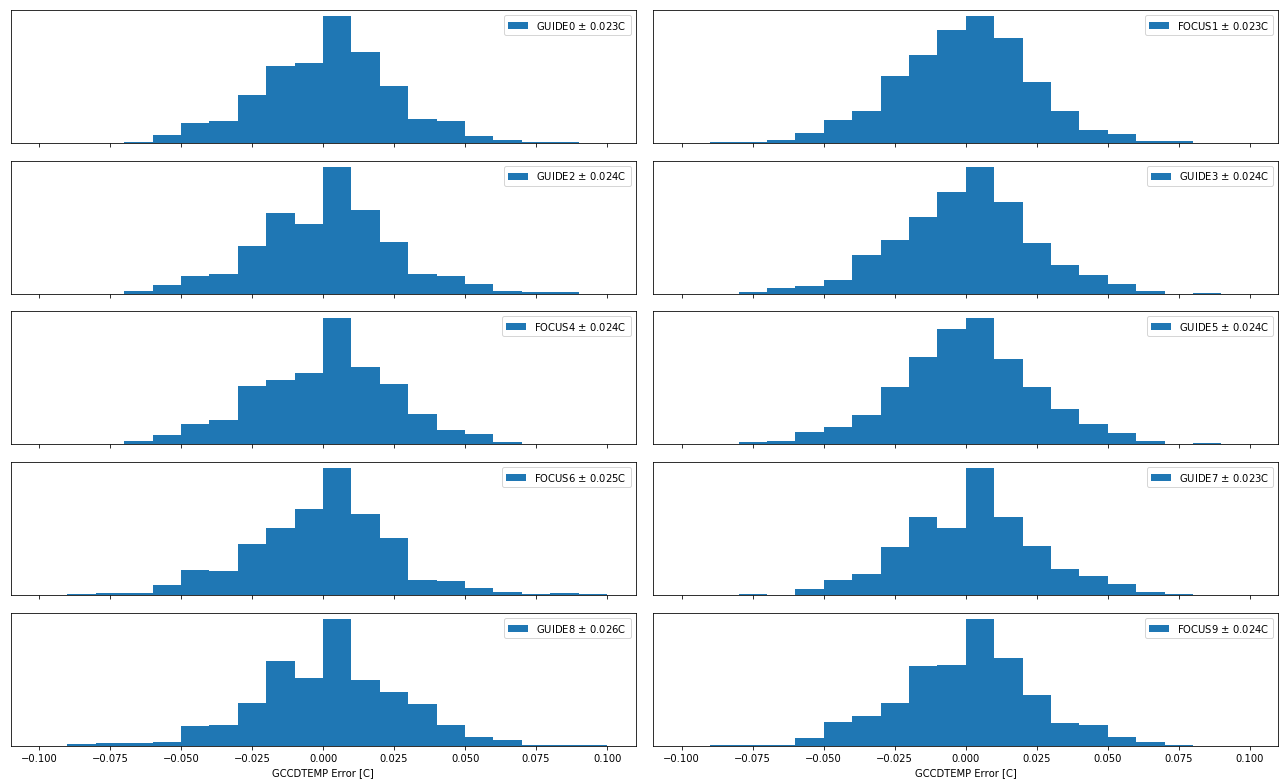

In [37]:
def plot_temp_residuals(save='GFA_temp_accuracy.png'):
    results = {}
    fig, axes = plt.subplots(5, 2, sharex=True, figsize=(18, 11))
    bins = np.linspace(-0.1, 0.1, 21)
    for k, gfa in enumerate(desietcimg.gfa.GFACamera.gfa_names):
        ax = axes[k // 2, k % 2]
        Tresidual = []
        # Loop over dark sequences.
        for first, data in darks.items():
            # Extract the timestamps and header GCCDTEMP values for each exposure.
            mjd = data['mjd']
            dt = (mjd[k] - mjd.min()) * 24 * 60
            T = data['temp'][k]
            # Build a linear model for temperature vs time.
            Tmodel = scipy.interpolate.interp1d(
                data['dtsum'][k], data['tempsum'][k], kind='linear',
                copy=False, assume_sorted=True, fill_value='extrapolate')
            # Calculate actual - model residuals for each exposure.
            Tresidual.append(T - Tmodel(dt))
        Tresidual = np.concatenate(Tresidual)
        Terror = np.std(Tresidual)
        label = '{0} $\pm$ {1:.3f}C'.format(gfa, Terror)
        ax.hist(Tresidual, bins=bins, histtype='stepfilled', density=True, label=label)
        ax.legend()
        ax.set_yticks([])
        if k in (8, 9):
            ax.set_xlabel('GCCDTEMP Error [C]')
    plt.tight_layout()
    if save:
        plt.savefig(save)    

plot_temp_residuals()